# Mothers’ Lifestyle Characteristics Impact on Infant Birth Weight

Team B1: Ayingfu (#82951880), Bryant Hartono (#66162710), Jeremy Davies (#74883935), Jingxuan Ma (#49183288)

## 1. Introduction

#### 1.1 Data Source

The dataset for this project is the “birthwt” dataset provided with the Support Functions and Datasets for Venables and Ripley's MASS package in R.

Relevant citation for the MASS package:  
Venables WN, Ripley BD (2002). Modern Applied Statistics with S, Fourth edition. Springer, New York. ISBN 0-387-95457-0, https://www.stats.ox.ac.uk/pub/MASS4/.

#### 1.2 Dataset Description

**Dataset detail**  
The dataset consists of 189 observations with 10 columns (refer to column details explained below). Data was collected at Baystate Medical Center, Springfield, Massachusetts during 1986, with no specific setting. Study subjects were 189 mothers, 59 of which had low birth weight babies and 130 of which had normal birth weight babies. Characteristics of the mother’s lifestyle and health factors were collected during the pregnancy and the weight of the newborn infant was recorded at birth.

**Response variable**  
Neonate birth weight (‘bwt’), measured in grams.

**Potential explanatory variables**  
1) Continuous variables  
- age: Mother’s age (years)
- lwt: Mother's weight (pounds) at last menstrual period
- ptl: Number of previous premature labors
- ftv: Number of physician visits during the first trimester  
  
2) Categorical variables  
- race: Mother's race ( “1” = white, “2” = black, “3” = other) 
- smoke: Smoking status during the pregnancy. (“1”=Yes,”0”= No)
- ht: History of hypertension. (“1”=Yes,”0”= No)
- ui: Presence of uterine irritability. (“1”=Yes,”0”= No)

#### 1.3 Research Question / Motivation

There is some evidence (and some speculation) to suggest that heavier babies have lower infant mortality rates and perhaps also lower risk of cardiovascular disease later in life. Therefore, our group is interested in studying the factors that explain an infant’s birth weight. In particular, we are interested in whether the weight of the mother, the mother’s race, the smoking status of the mother, among other variables, affect the infant birth weight.  
  
If we can identify the contributing factors and reasonably predict a baby’s neonate birth weight, this would enable better preparation of healthcare at birth. For example, if we develop a model that predicts a baby will have a low birth weight, then the obstetrician could recommend for the mother to have the birth at a dedicated neonatal ward, where there are more specialized resources to ensure a healthy birth.

## 2. Analysis

#### 2.1 Reading in data

In [23]:
# Necessary libraries to install:
# - 'tidyverse', 'cowplot' , 'tidymodels', 'repr', 'MASS', 'leaps', 'GGally'

# Load in libaries
library(tidyverse)
library(cowplot)
library(tidymodels)
library(repr)
library(MASS)
library(GGally)

# Suppress table outputs to a manageable # of rows
options(repr.matrix.max.rows = 10)

# Read data
raw_data <- birthwt

#### 2.2 Clean and wrangle data

In [24]:
# Select only potentially meaningful columns (variables) and re-name categorical levels for easier understanding
data_bwt <- raw_data %>%
    dplyr::select(age, lwt, ptl, ftv, race, smoke, ht, ui, bwt) %>%
    mutate(race = case_when(
      race == 1  ~ "White",
      race == 2  ~ "Black",
      TRUE       ~ "Other"
    ), 
    smoke = case_when(smoke == 0  ~ "No", smoke == 1  ~ "Yes"), 
    ht = case_when(ht == 0  ~ "No", ht == 1  ~ "Yes"),
    ui = case_when(ui == 0  ~ "No", ui == 1  ~ "Yes")
)

# Convert categorical variables to factors in R
data_bwt$race <- as.factor(data_bwt$race)
data_bwt$smoke <- as.factor(data_bwt$smoke)
data_bwt$ht <- as.factor(data_bwt$ht)
data_bwt$ui <- as.factor(data_bwt$ui)

#  relevel race based on highest observation count
data_bwt$race <- relevel(data_bwt$race, ref="White")  

# Inspect clean dataframe
head(data_bwt,5)

,age,lwt,ptl,ftv,race,smoke,ht,ui,bwt
,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<int>
85,19,182,0,0,Black,No,No,Yes,2523
86,33,155,0,3,Other,No,No,No,2551
87,20,105,0,1,White,Yes,No,No,2557
88,21,108,0,2,White,Yes,No,Yes,2594
89,18,107,0,0,White,Yes,No,Yes,2600


#### 2.3 Tabular Summary of Data

In [25]:
summary(data_bwt)

      age             lwt             ptl              ftv            race   
 Min.   :14.00   Min.   : 80.0   Min.   :0.0000   Min.   :0.0000   White:96  
 1st Qu.:19.00   1st Qu.:110.0   1st Qu.:0.0000   1st Qu.:0.0000   Black:26  
 Median :23.00   Median :121.0   Median :0.0000   Median :0.0000   Other:67  
 Mean   :23.24   Mean   :129.8   Mean   :0.1958   Mean   :0.7937             
 3rd Qu.:26.00   3rd Qu.:140.0   3rd Qu.:0.0000   3rd Qu.:1.0000             
 Max.   :45.00   Max.   :250.0   Max.   :3.0000   Max.   :6.0000             
 smoke       ht        ui           bwt      
 No :115   No :177   No :161   Min.   : 709  
 Yes: 74   Yes: 12   Yes: 28   1st Qu.:2414  
                               Median :2977  
                               Mean   :2945  
                               3rd Qu.:3487  
                               Max.   :4990  

#### 2.4 Visual Summary of Data

##### 2.4.1 Scatterplot grid for numeric variables vs. birthweight

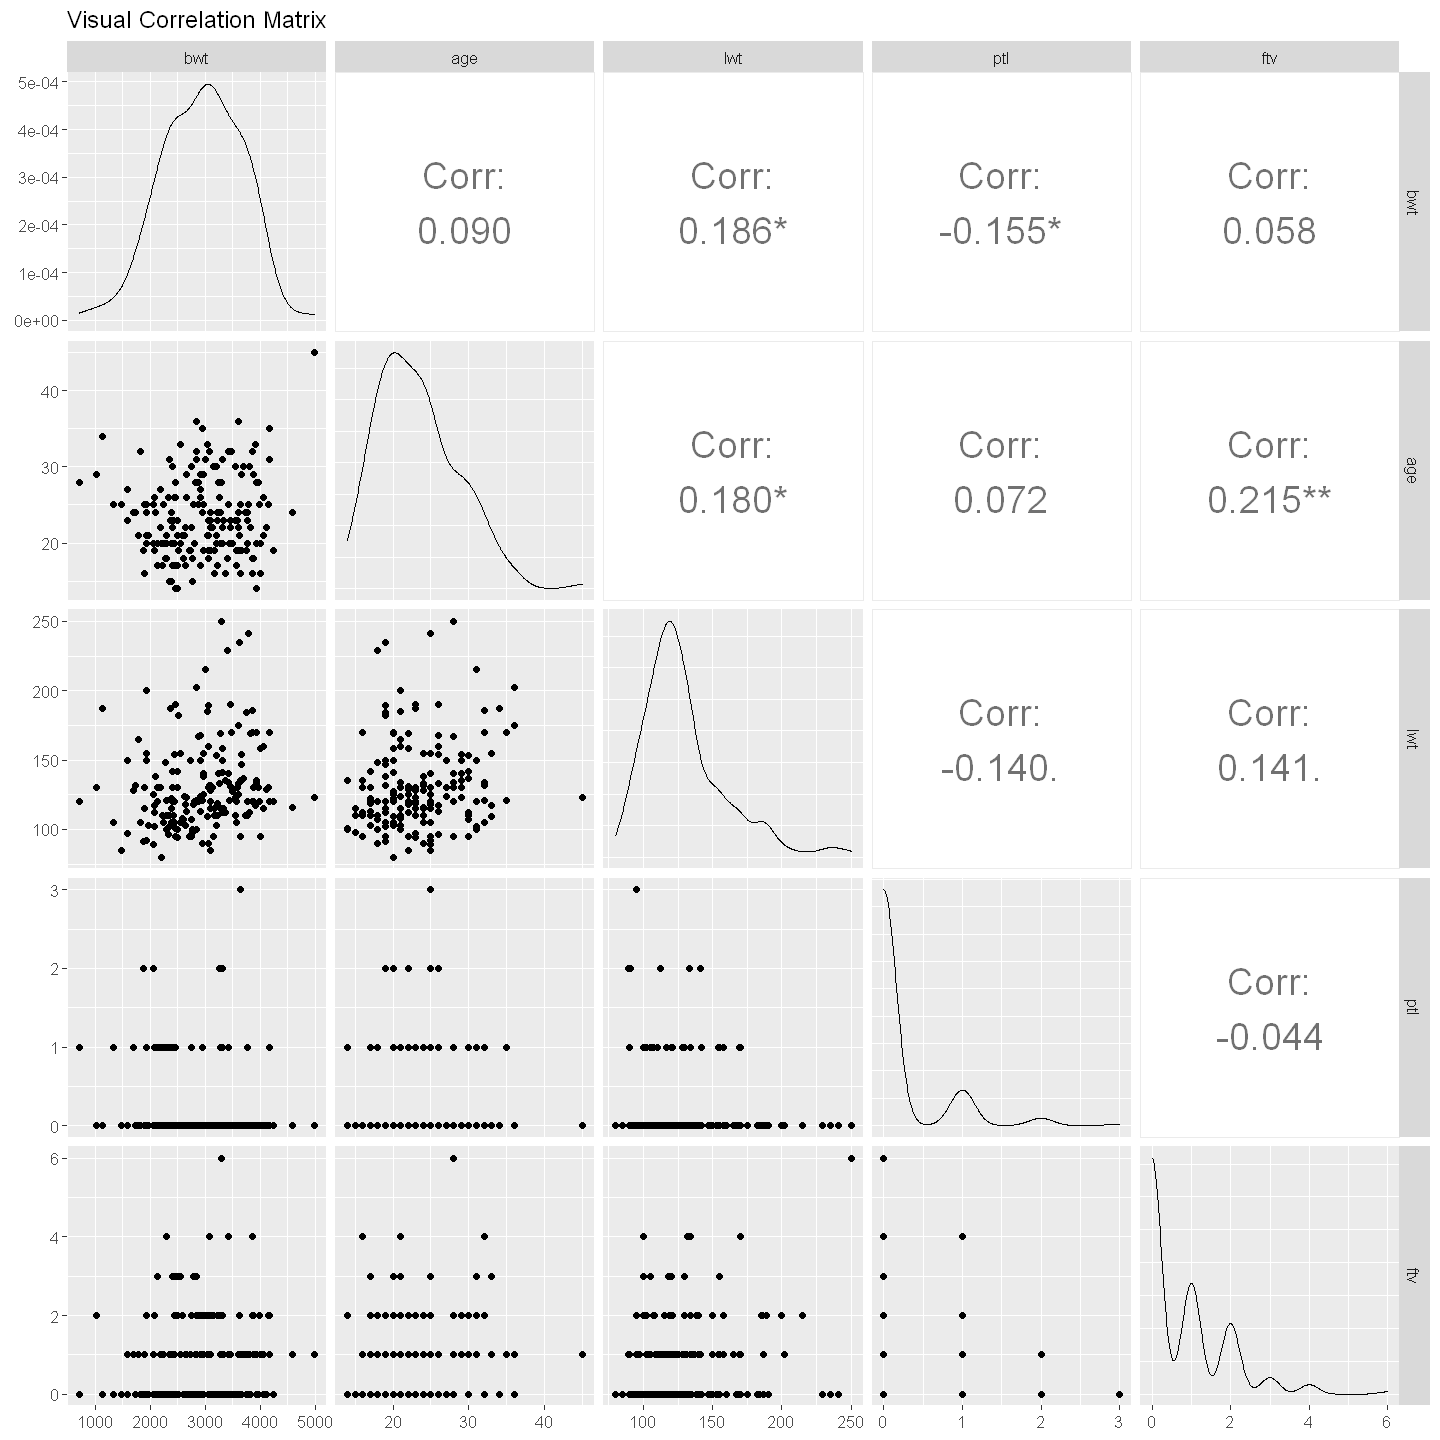

In [26]:
# Set plot output size
options(repr.plot.width = 12, repr.plot.height = 12)

# Get df with only the numeric variables (exclude factor vars for now)
data_bwt_numeric <- data_bwt %>%
    dplyr::select(bwt, age, lwt, ptl, ftv)
    

# Construct visual correlation matrix of only numeric variables
# PURPOSE: Explore correlations between explanatory variables themselves and with response variable bwt (birthweight)
ggpairs(data_bwt_numeric,
        title = "Visual Correlation Matrix",
         upper = list(continuous = wrap("cor", size = 8)))  +
theme(text = element_text(size=12))

**Comments**  
- The baby's birth weight has a weak, positive correlation with with the mother's weight at the last menstrual period (r=0.18). This makes intuitive sense because we would expect on average that mothers of larger stature tend to have larger newborn babies.
- The baby's birth weight has a weak, positive correlation with the mother's age (r=0.09).
- The baby's birth weight has a weak, negative correlation with the number of previous premature labours (r=-0.155). This indicates that a mother who was prone to premature labours in the past may be prone to it again.
- We also remark the presence of collinearity between explantory variables of mother's age and # of physician visits in the first trimester (r=0.215), and the mother's age and her weight (r=0.18). We will bear these trends in mind when fitting linear models in later sections of this report. 
  
Note: The diagonal terms of the above chart represent a distribution of each respective numeric variable.

##### 2.4.1 Comparing baby birthweight by category

TODO: In one chart (look up arranging multiple plots on a page), produce boxplots showing btw against the various levels of the categorical variables.  There should be box plots for race, smoke, ht, ui

**Comments**   
TODO: Add comments on the box plot chart.

#### 2.5 Model Selection

TODO: Model selection using some method learnt such as best subsets and/or validation set approach (test/train split).  See Lab 8 and Assignment 2 for inspiration.

#### 2.6 Residual Plot Analysis

TODO: Residual plots. Discuss whether residual assumptions are valid here.  
  
If necessary, re-fit model after transforming a variable, etc.

## 3. Conclusion

!!! TO BE COMPLETED (last)  

Should tie back to research question